# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Lines** 


## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (720, 1280, 3)


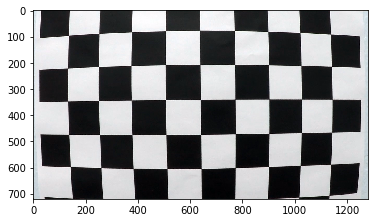

In [2]:
#reading in an image
image = cv2.imread('./camera_cal/calibration1.jpg')
#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)   # return image
plt.imsave('output_images/calibration_input_1.jpg', image)
plt.show()

## Camera Caliberation & Distortion Correction

In [3]:
objpoints = []  # 3D points in realworld 
imgpoints = []  # 2D points from camera images

ret = 0.0
mtx  = np.ndarray([])
dist = np.ndarray([])
rvecs = []
tvecs = []
    
def calibrateCam():
    nx = 9 # corners along each row
    ny = 6 # corners slong each column
    images = glob.glob('./camera_cal/calibration*.jpg')
    
    #Prepare object points
    objp = np.zeros((nx*ny,3),np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
    img_cnt = 0
    for fname in images:
        filename = fname.split('/')[-1]
        filename = filename.split('\\')[-1]
        #read image
        image = cv2.imread(fname)
        
        #convert to grayscale
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        
#         plt.imshow(gray,cmap='gray')
#         plt.show()
        
        #find corners
        ret, corners = cv2.findChessboardCorners(gray, (nx,ny), None)
        if(ret==True):
            imgpoints.append(corners)
            objpoints.append(objp)
            
            # draw Chessboard Corners
            image = cv2.drawChessboardCorners(image,(nx,ny),corners,ret)
            plt.imsave('camera_cal/output_corners/corners_'+filename, image)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    return mtx, dist
    
def convert2gray(img, fmt = 'BGR'):
    if(fmt == 'RGB'):
        return cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    else:
        return cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)


def undistort(img, mtx, dist):
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist

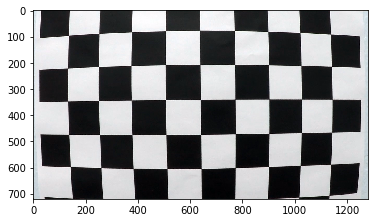

This is an undistorted image:


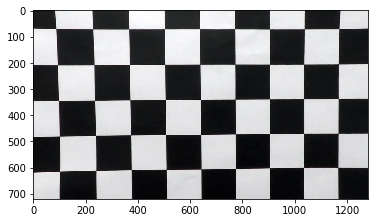

In [4]:
mtx, dist = calibrateCam()

#reading in an image
image = cv2.imread('./camera_cal/calibration1.jpg')
plt.imshow(image)   # return image
plt.imsave('output_images/calibration_input_1.jpg', image)
plt.show()
image = undistort(image, mtx, dist)
#printing out some stats and plotting
print('This is an undistorted image:')
plt.imshow(image)   # return image
plt.imsave('output_images/undistorted_input_1.jpg', image)
plt.show()

## Gradient and Direction Threshold 

In [5]:
def abs_sobel_thresh(sobel, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
#     if(orient == 'x'):
#         sobel = cv2.Sobel(gray, cv2.CV_64F,1,0,sobel_kernel)
#     elif(orient == 'y'):
#         sobel = cv2.Sobel(gray, cv2.CV_64F,0,1,sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    sobel_abs = np.absolute(sobel)
    
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    sobel_scaled = np.uint8(255.0*sobel_abs/np.max(sobel_abs))
    
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sobel_mask = np.zeros_like(sobel_scaled)
    
    sobel_mask[(sobel_scaled>=thresh[0]) & (sobel_scaled<=thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    grad_binary = sobel_mask    # Apply threshold
    return grad_binary

def mag_thresh(sobel_x, sobel_y, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
        # Apply the following steps to img
        
#     # 2) Take the gradient in x and y separately
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
#     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    
    # 3) Calculate the magnitude 
    sobel_abs = np.sqrt(np.square(sobel_x)+ np.square(sobel_y))
    
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    sobel_scaled = np.uint8(255.0*sobel_abs/np.max(sobel_abs))
    
    # 5) Create a binary mask where mag thresholds are met
    sobel_mask = np.zeros_like(sobel_scaled)
    sobel_mask[(sobel_scaled>=mag_thresh[0])&(sobel_scaled<=mag_thresh[1])] = 1
    
    # 6) Return this mask as your binary_output image
    mag_binary = sobel_mask
    # Apply threshold
    return mag_binary

def dir_threshold(sobel_x, sobel_y, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
#     # 2) Take the gradient in x and y separately
#     sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize = sobel_kernel)
#     sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize = sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    sobelx_abs = np.absolute(sobel_x)
    sobely_abs = np.absolute(sobel_y)
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    sobel_dir = np.arctan2(sobely_abs, sobelx_abs)
    # 5) Create a binary mask where direction thresholds are met
    sobel_mask = np.zeros_like(sobel_dir)
    sobel_mask[(sobel_dir>=thresh[0])&(sobel_dir<=thresh[1])]=1
    # 6) Return this mask as your binary_output image
    dir_binary = sobel_mask
    # Apply threshold
    return dir_binary


## Color Thresholds

In [6]:
def hls_threshold(image, ch = 's', thresh = (180,255)):
    
    hls = cv2.cvtColor(image,cv2.COLOR_RGB2HLS)
    if(ch == 'h'):
        H = hls[:,:,0]
        h_binary = np.zeros_like(H)
        h_binary[(H>=thresh[0])&(H<=thresh[1])] = 1
        return h_binary
    elif(ch == 'l'):
        L = hls[:,:,1]
        l_binary = np.zeros_like(L)
        l_binary[(L>=thresh[0])&(L<=thresh[1])] = 1
        return l_binary
    else:
        S = hls[:,:,2]
        s_binary = np.zeros_like(S)
        s_binary[(S>=thresh[0])&(S<=thresh[1])] = 1
        return s_binary 

def rgb_threshold(image, ch = 'r', thresh = (180,255)):
    rgb = image
    if(ch == 'g'):
        G = rgb[:,:,1]
        g_binary = np.zeros_like(G)
        g_binary[(G>=thresh[0])&(G<=thresh[1])] = 1
        return g_binary
    elif(ch == 'b'):
        B = rgb[:,:,2]
        b_binary = np.zeros_like(B)
        b_binary[(B>=thresh[0])&(B<=thresh[1])] = 1
        return b_binary
    else:
        R = rgb[:,:,0]
        r_binary = np.zeros_like(R)
        r_binary[(R>=thresh[0])&(R<=thresh[1])] = 1
        return r_binary 
      

In [7]:
def apply_color_thresh(undist):
      
    #Apply color threshold
#   s_binary = hls_threshold(undist, ch = 's', thresh = (150,255))
    s_binary = hls_threshold(undist, ch = 's', thresh = (90,255))
    h_binary = hls_threshold(undist, ch = 'h', thresh = (0,100))
    l_binary = hls_threshold(undist, ch = 'l', thresh = (180,255))
    
#     r_binary = rgb_threshold(undist, ch = 'r', thresh = (220,255))
    r_binary = rgb_threshold(undist, ch = 'r', thresh = (200,255))
    g_binary = rgb_threshold(undist, ch = 'g', thresh = (150,255))
    b_binary = rgb_threshold(undist, ch = 'b', thresh = (150,255))   
    
    color_binary = np.zeros_like(s_binary)
    color_binary[(s_binary == 1) & (r_binary == 1)] = 1
    
    return color_binary
    
def apply_grad_thresh(gray_undist):
    
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    sobel_x = cv2.Sobel(gray_undist, cv2.CV_64F, 1, 0, ksize = ksize)
    sobel_y = cv2.Sobel(gray_undist, cv2.CV_64F, 0, 1, ksize = ksize)
    gradx = abs_sobel_thresh(sobel_x, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    grady = abs_sobel_thresh(sobel_y, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(sobel_x,sobel_y, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(sobel_x,sobel_y, sobel_kernel=15, thresh=(np.pi/4, np.pi/2))
    grad_binary = np.zeros_like(dir_binary)
    grad_binary[((gradx == 1) & (dir_binary == 1))] = 1 # | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return grad_binary

def apply_filter(image_undist):
    
    gray_undist = convert2gray(image_undist, fmt='RGB')
    
    color_binary = apply_color_thresh(image_undist)
    grad_binary = apply_grad_thresh(gray_undist)
    
    combined = np.zeros_like(grad_binary)
    combined[(grad_binary == 1) | (color_binary == 1)] = 1   
        
    return gray_undist, color_binary, grad_binary, combined

## Perspective Transform

In [8]:
src_x = (200,170,605,605)
src_y = (0,440)
# src_x = (200,170,580,580)
# src_y = (0,460)
dst_x = (350,1280-320)


def warp(img):
    # Pass in your image into this function
    # Write code to do the following steps

    img_size = (img.shape[1],img.shape[0])
    
    # a) define 4 source points src = np.float32([[,],[,],[,],[,]])
    src = np.float32([[src_x[0],img_size[1]-src_y[0]], [img_size[0]-src_x[1],img_size[1]-src_y[0]], [img_size[0]-src_x[2], src_y[1]], [src_x[3],src_y[1]]]) 
    
    # b) define 4 destination points dst = np.float32([[,],[,],[,],[,]])
    dst = np.float32([[dst_x[0],img_size[1]],[dst_x[1],img_size[1]],[dst_x[1],1],[dst_x[0],1]])

    # c) use cv2.getPerspectiveTransform() to get M, the transform matrix
    M = cv2.getPerspectiveTransform(src,dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)

    # d) use cv2.warpPerspective() to warp your image to a top-down view
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
     
    return warped, M, Minv

## Draw region of interest

In [9]:
def draw_roi(img, img_type='src'):
    img_size = (img.shape[1],img.shape[0])
    if(img.ndim==2):
        if(np.amax(img)==1): # in case of binary image - convert to grayscale
            img = img*255
        img = np.dstack([img, img, img]) # convert to rgb to add red region of interest

    if(img_type=='dst'):
        dst = np.float32([[dst_x[0],img_size[1]],[dst_x[1],img_size[1]],[dst_x[1],0],[dst_x[0],0]])
        #Draw out region of interest perimeter on original image
        img_cpy = np.copy(img) # creating a copy of original image to draw region of interest
        cv2.polylines(img_cpy,np.int32([dst]),True,(255,0,0),4)
        return img_cpy, dst

    else:
    # a) define 4 source points src = np.float32([[,],[,],[,],[,]])
        src = np.float32([[src_x[0],img_size[1]-src_y[0]], [img_size[0]-src_x[1],img_size[1]-src_y[0]], [img_size[0]-src_x[2], src_y[1]], [src_x[3],src_y[1]]])   
        #Draw out region of interest perimeter on original image
        img_cpy = np.copy(img) # creating a copy of original image to draw region of interest
        cv2.polylines(img_cpy,np.int32([src]),True,(255,0,0),4)
        return img_cpy, src


In [10]:
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
image = undistort(image, mtx, dist)
img_roi, src = draw_roi(image)
plt.imshow(img_roi)
plt.show()

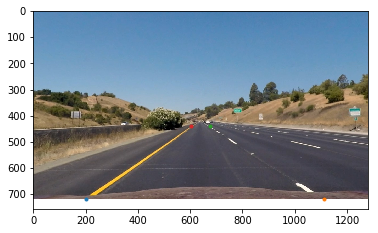

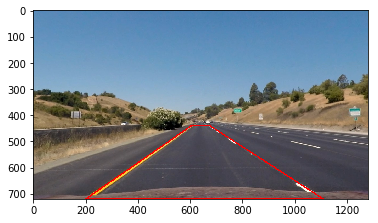

In [11]:
# mtx, dist = calibrateCam()
image = cv2.imread('test_images/straight_lines1.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image = undistort(image, mtx, dist)
img_roi, src = draw_roi(image)
plt.imshow(image)
plt.plot(src[0][0],src[0][1],'.')
plt.plot(src[1][0],src[1][1],'.')
plt.plot(src[2][0],src[2][1],'.')
plt.plot(src[3][0],src[3][1],'.')
plt.show()
plt.imshow(img_roi)
plt.show()
plt.imsave('output_images/roi.jpg', img_roi)

## Sliding Window and Polynomial fit

In [12]:
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

def polyFit(binary_warped, histogram, view='None'):
    global left_lane_inds
    global right_lane_inds
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 4) 
#         print('\n',win_xleft_low,win_y_low,win_xleft_high,win_y_high)
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 4) 
#         print(win_xright_low,win_y_low,win_xright_high,win_y_high)

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    lane_window = []
    lane_poly = []
    if((view=='all') or (view=='slide_window')):
        lane_window = viewSlideWin(binary_warped, out_img)
    if((view=='all') or (view=='lane_poly')):
        lane_poly = viewLanePoly(binary_warped, left_fit, right_fit, ploty, left_fitx, right_fitx, margin)

    return lane_window, lane_poly, left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty , rightx, righty

def polyFit2(binary_warped,left_fit, right_fit, view='None'):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    global left_lane_inds
    global right_lane_inds
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
    left_fit[1]*nonzeroy + left_fit[2] + margin))) 

    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
    right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    lane_poly = []
    if((view=='all') or (view=='lane_poly')):
        lane_poly = viewLanePoly(binary_warped, left_fit, right_fit, ploty, left_fitx, right_fitx, margin)

    return lane_poly, left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty , rightx, righty

## Visualization Sliding Window

In [13]:
def viewSlideWin(binary_warped, out_img):
    global left_lane_inds
    global right_lane_inds
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    return out_img
    
def viewLanePoly(binary_warped, left_fit, right_fit, ploty, left_fitx, right_fitx, margin):
    global left_lane_inds
    global right_lane_inds
    
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                                  ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                                  ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    return result

## Radius of Curvature

In [14]:
def curveRadius(binary_warped, left_fit, right_fit, ploty):
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
#     print(left_curverad, right_curverad)
    # Example values: 1926.74 1908.48
    
    leftx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    rightx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
      
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now our radius of curvature is in meters
    
    return left_curverad, right_curverad
    # Example values: 632.1 m    626.2 m

## Mark Lane

In [15]:
def drawLane(undist, binary_warped, left_fit, right_fit, ploty, left_fitx, right_fitx, Minv):
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

#     left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
#     right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

## Pipeline on Test Images

straight_lines1.jpg
left_curvature:  3154.69600311 m ;  right_curvature:  1938.28685903 m


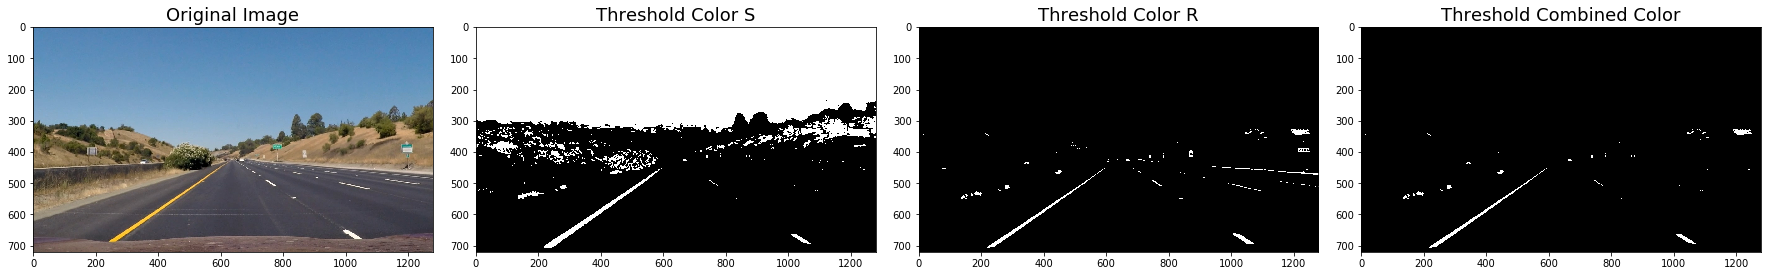

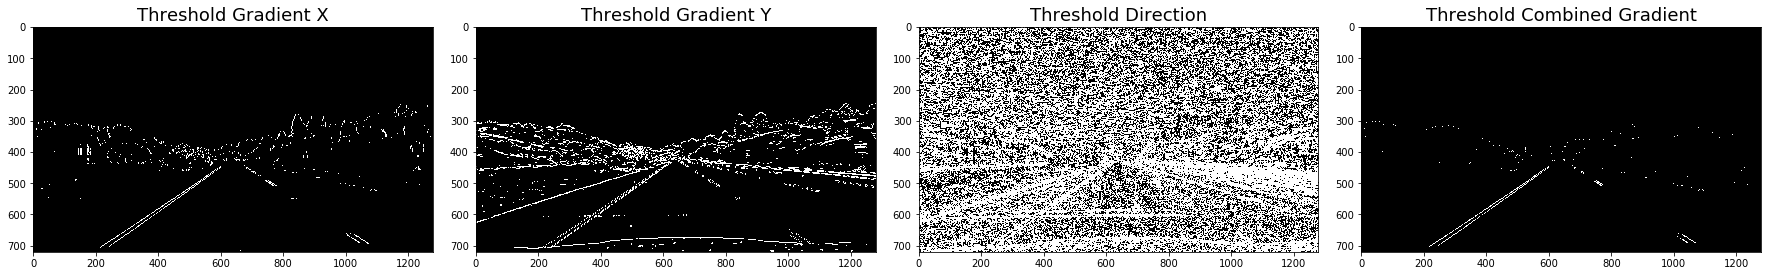

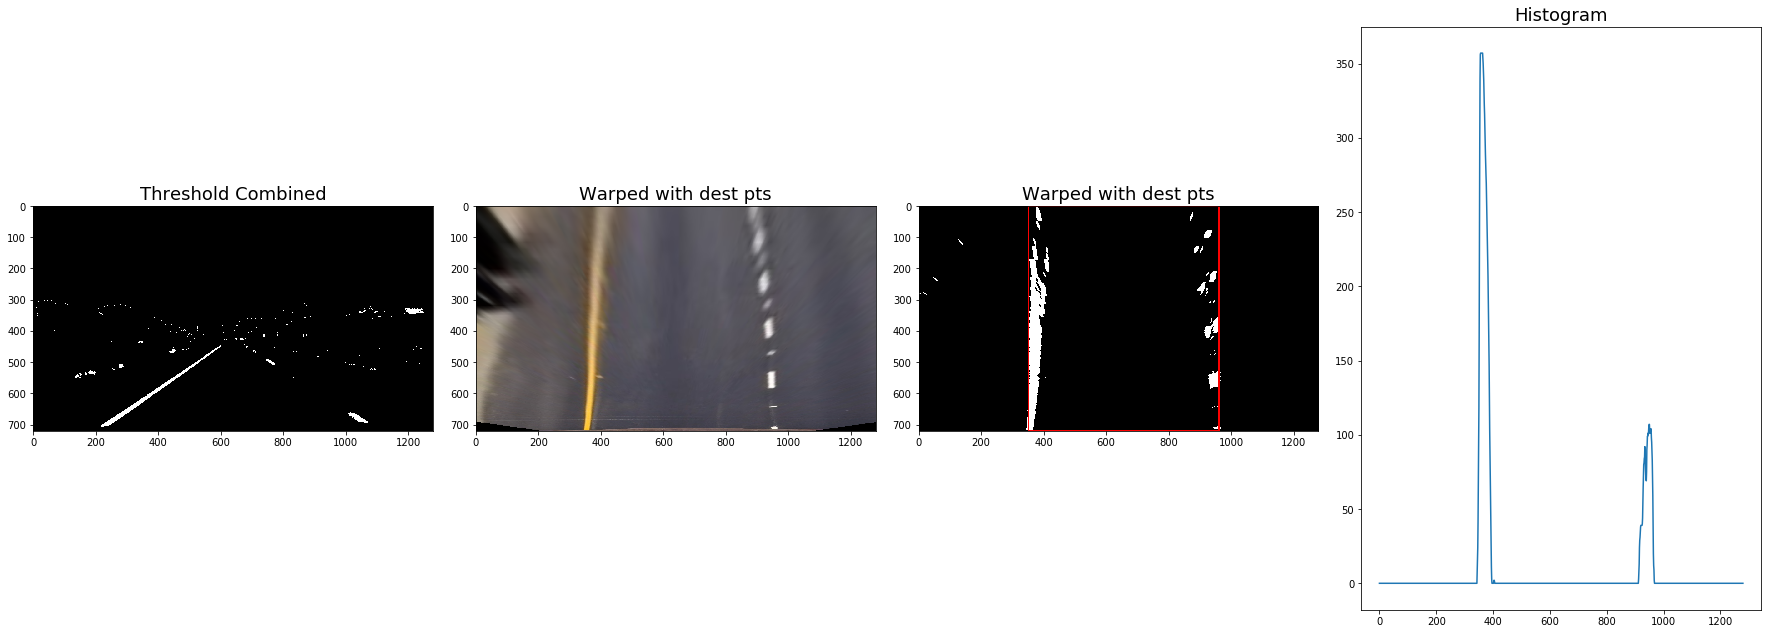

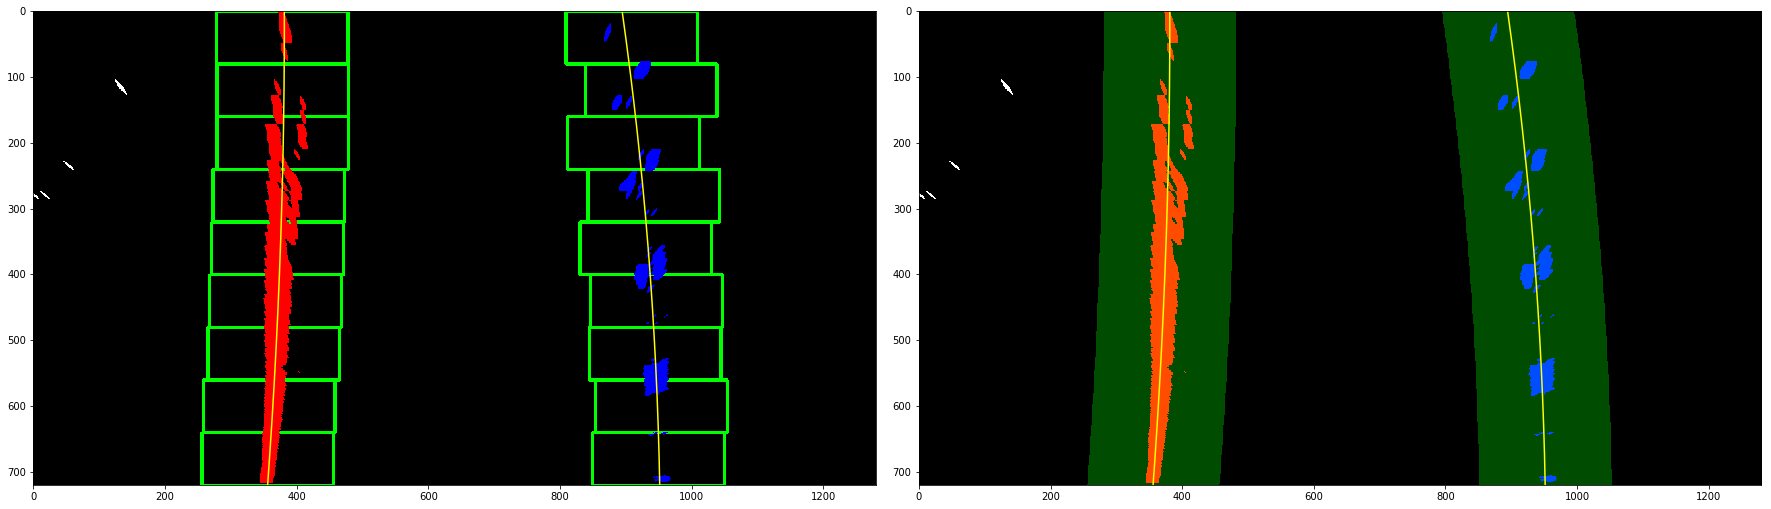

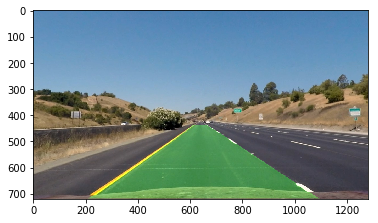

straight_lines2.jpg
left_curvature:  5810.24708427 m ;  right_curvature:  161693.623644 m


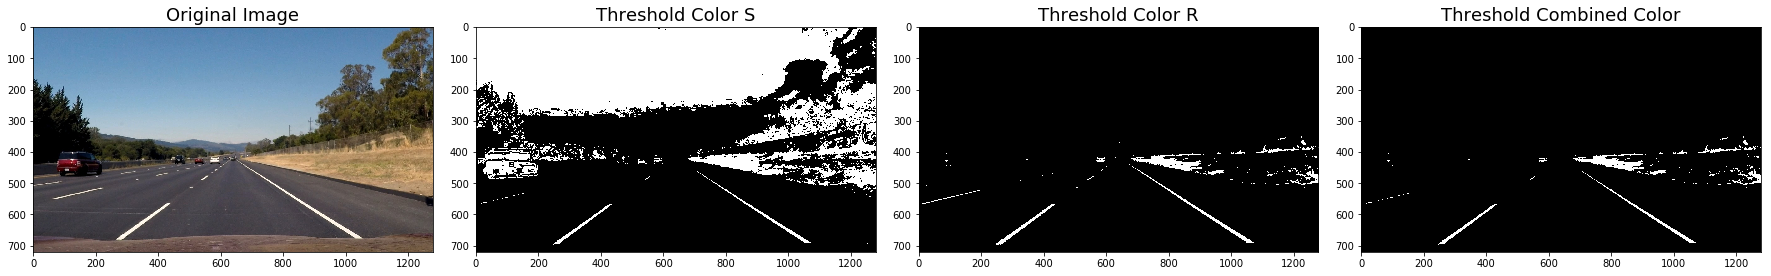

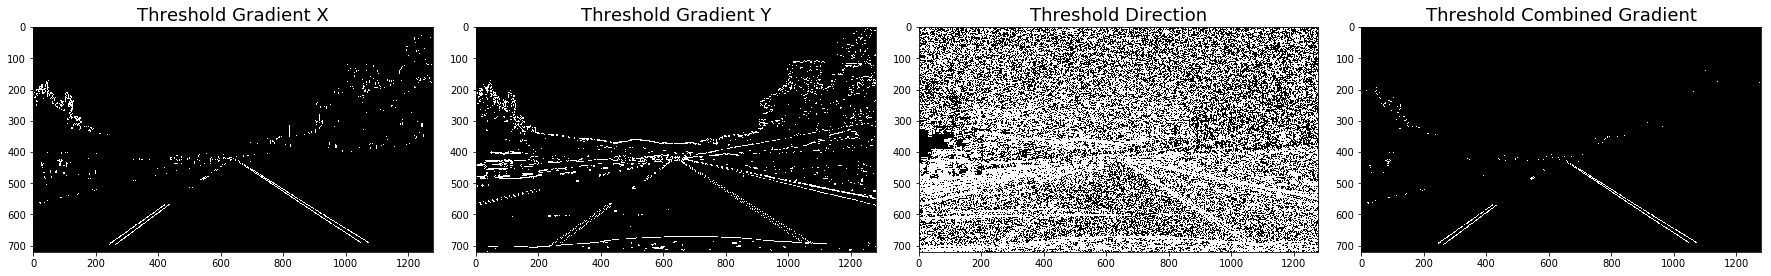

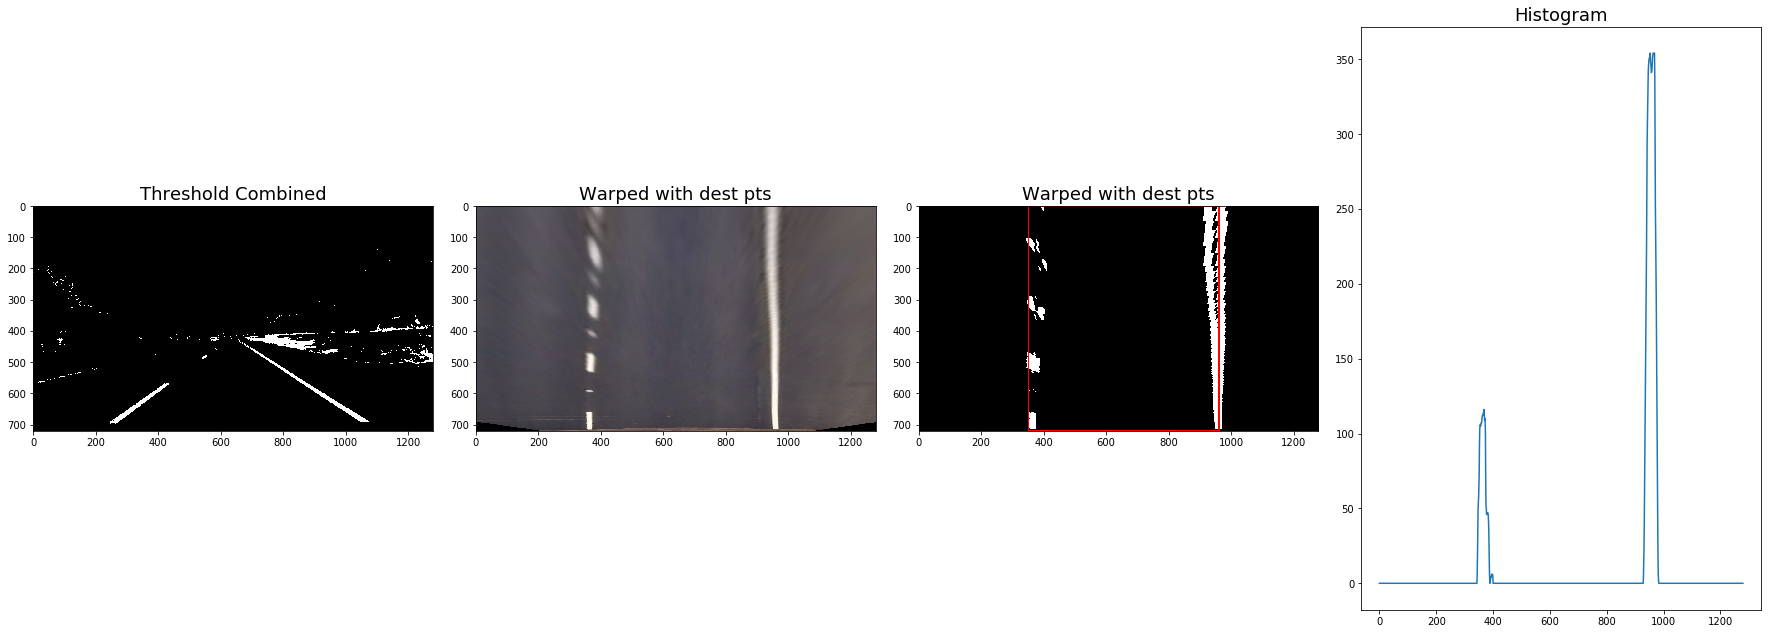

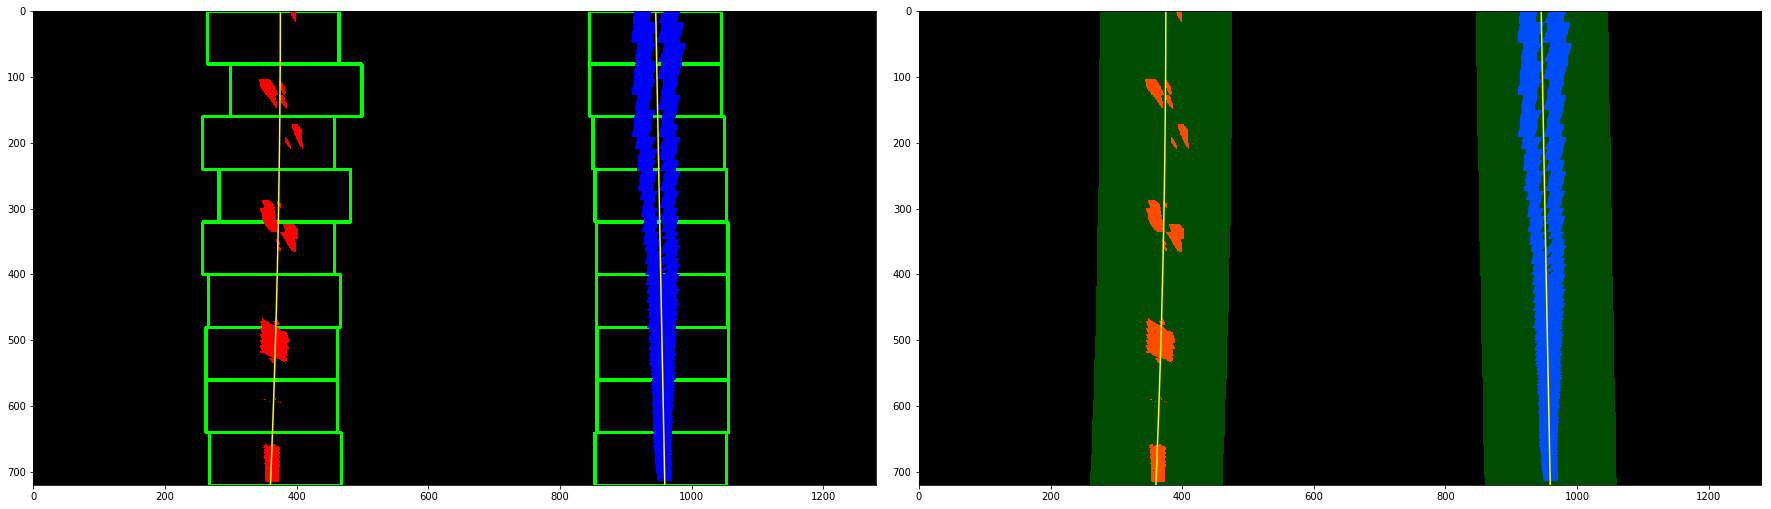

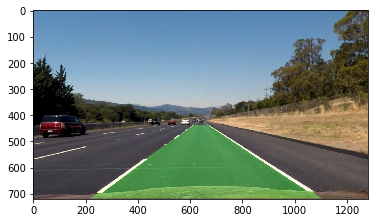

test1.jpg
left_curvature:  2630.71825408 m ;  right_curvature:  240.084417147 m


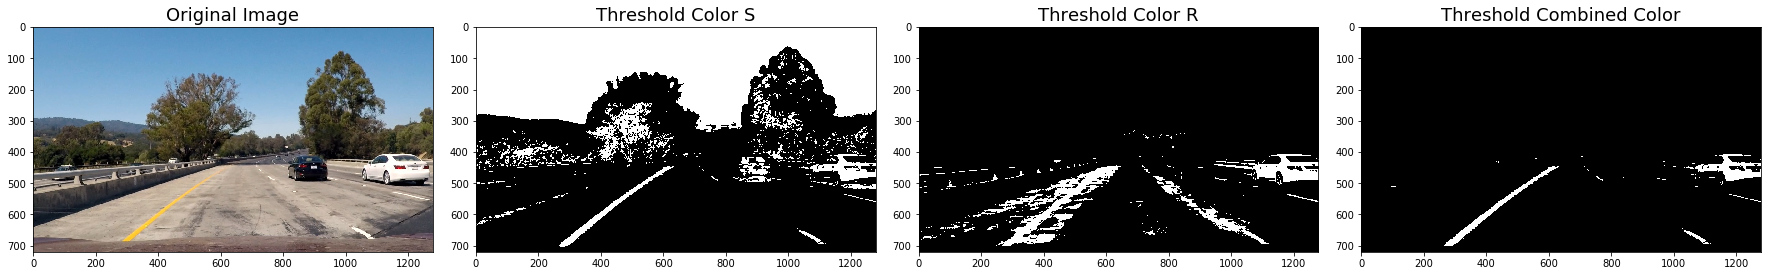

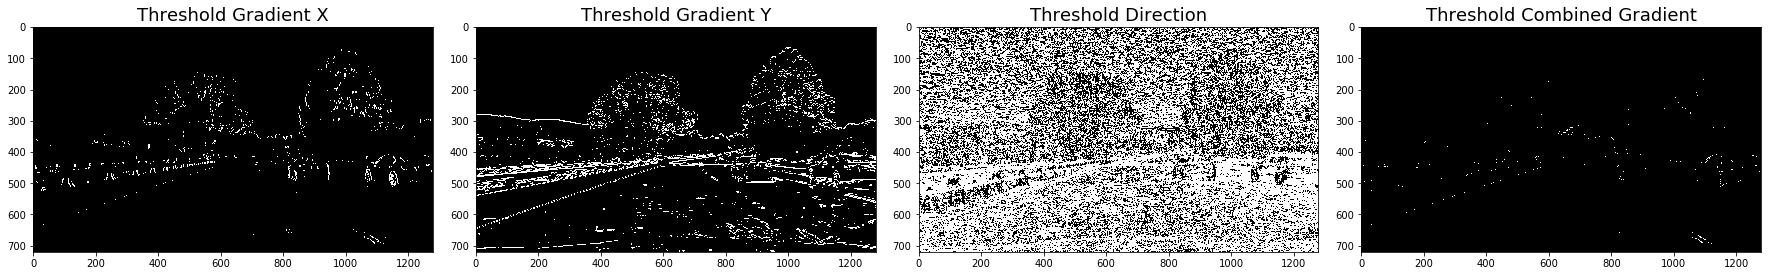

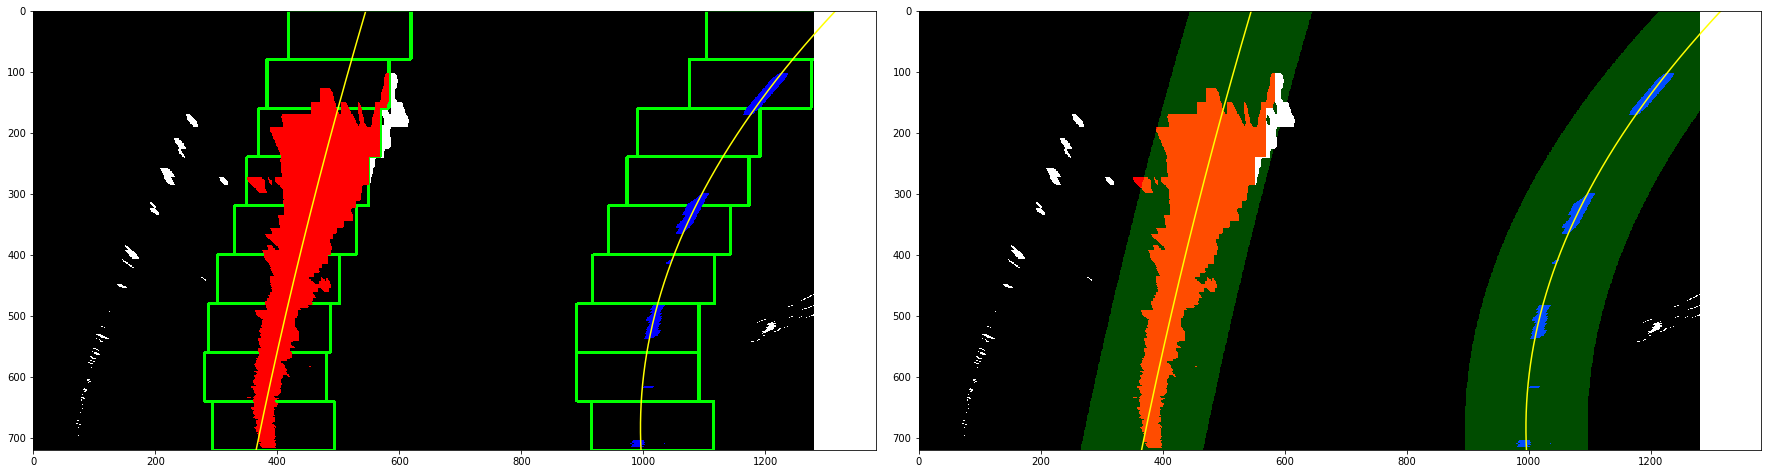

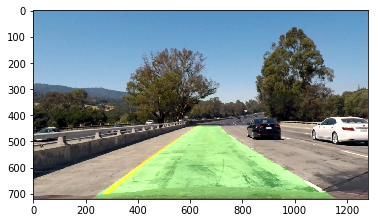

test2.jpg
left_curvature:  222.045849352 m ;  right_curvature:  377.330272821 m


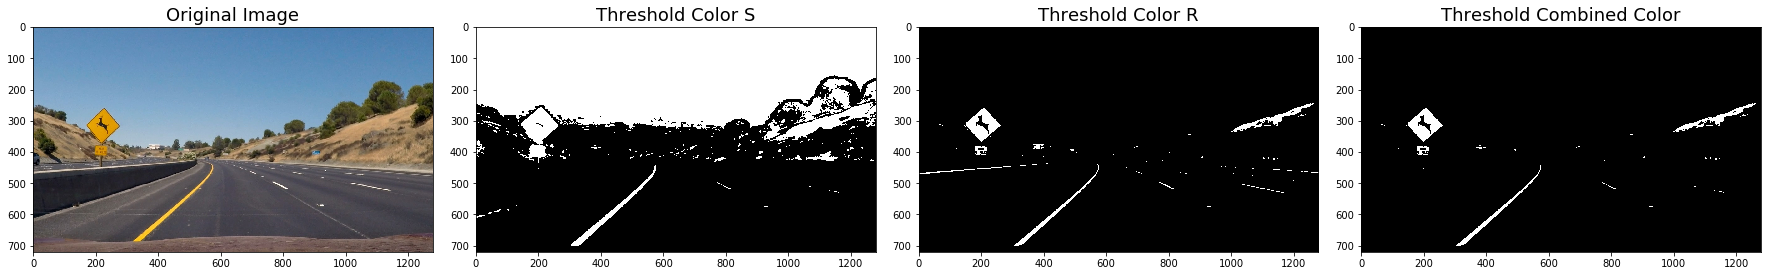

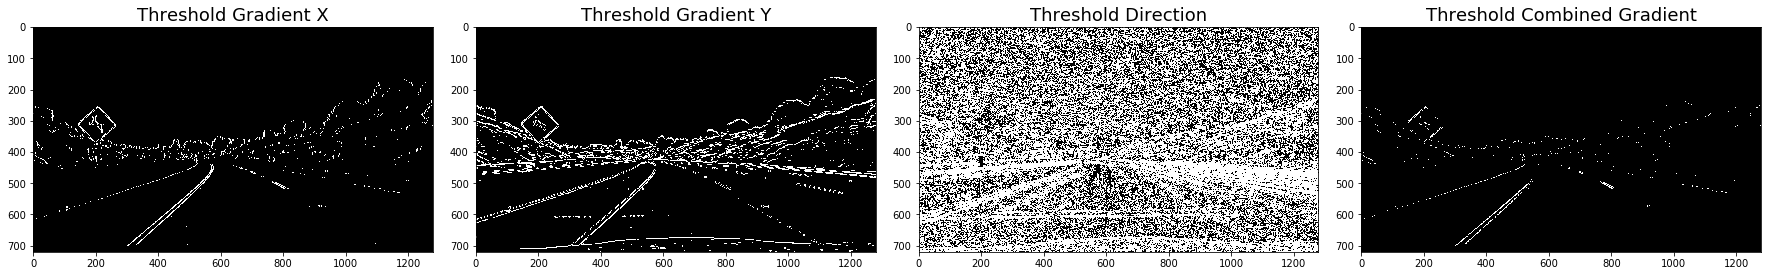

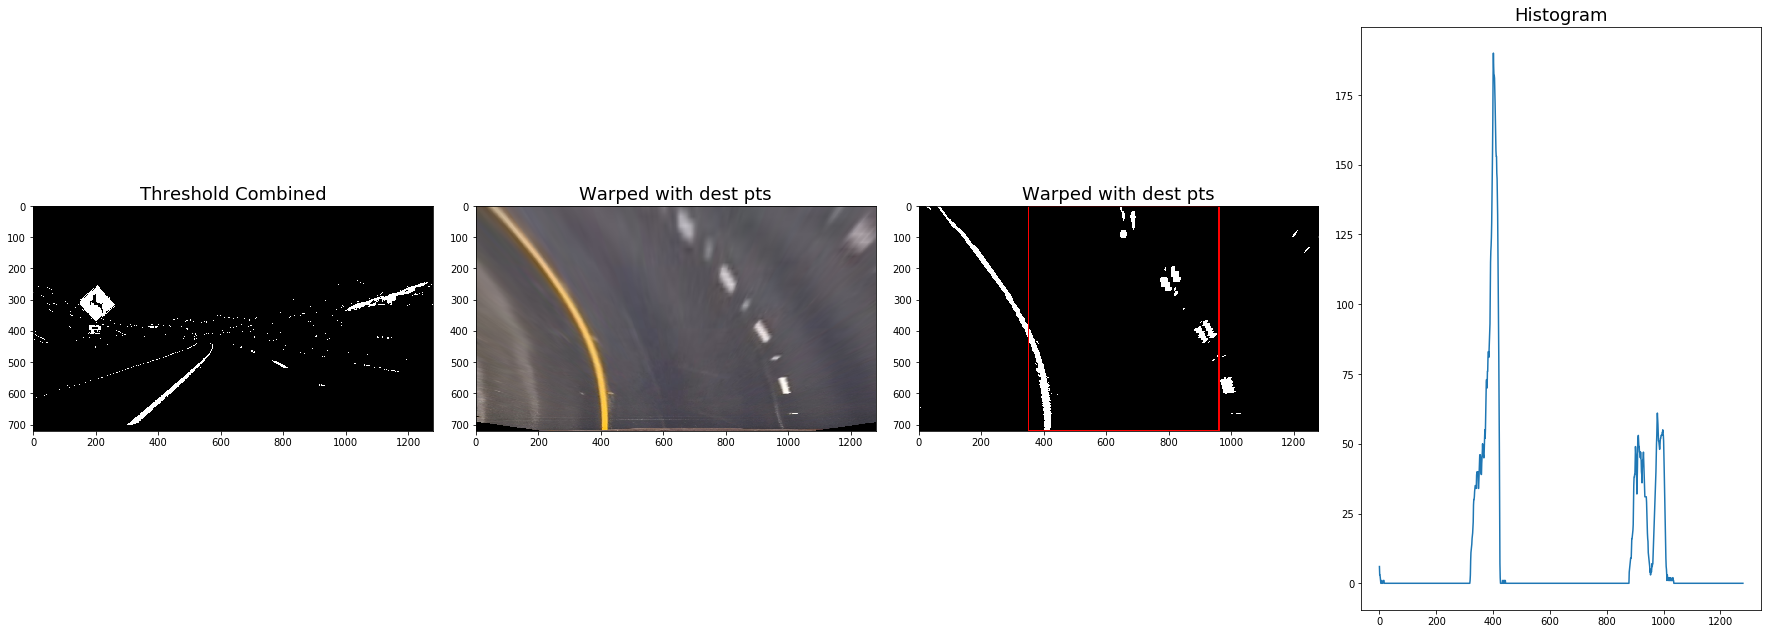

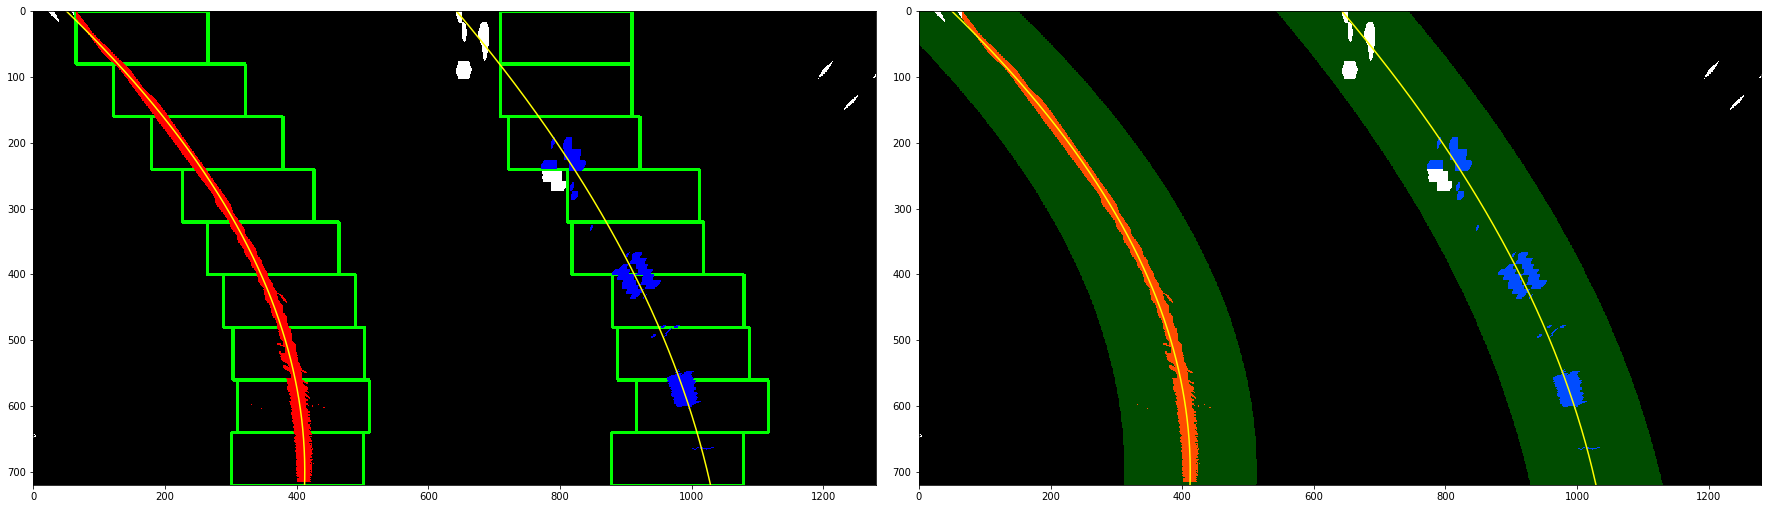

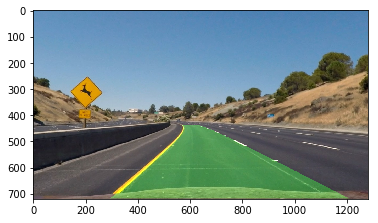

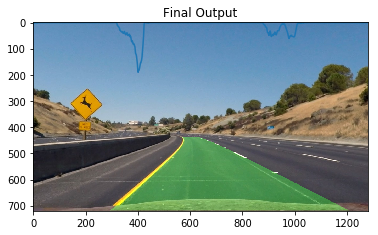

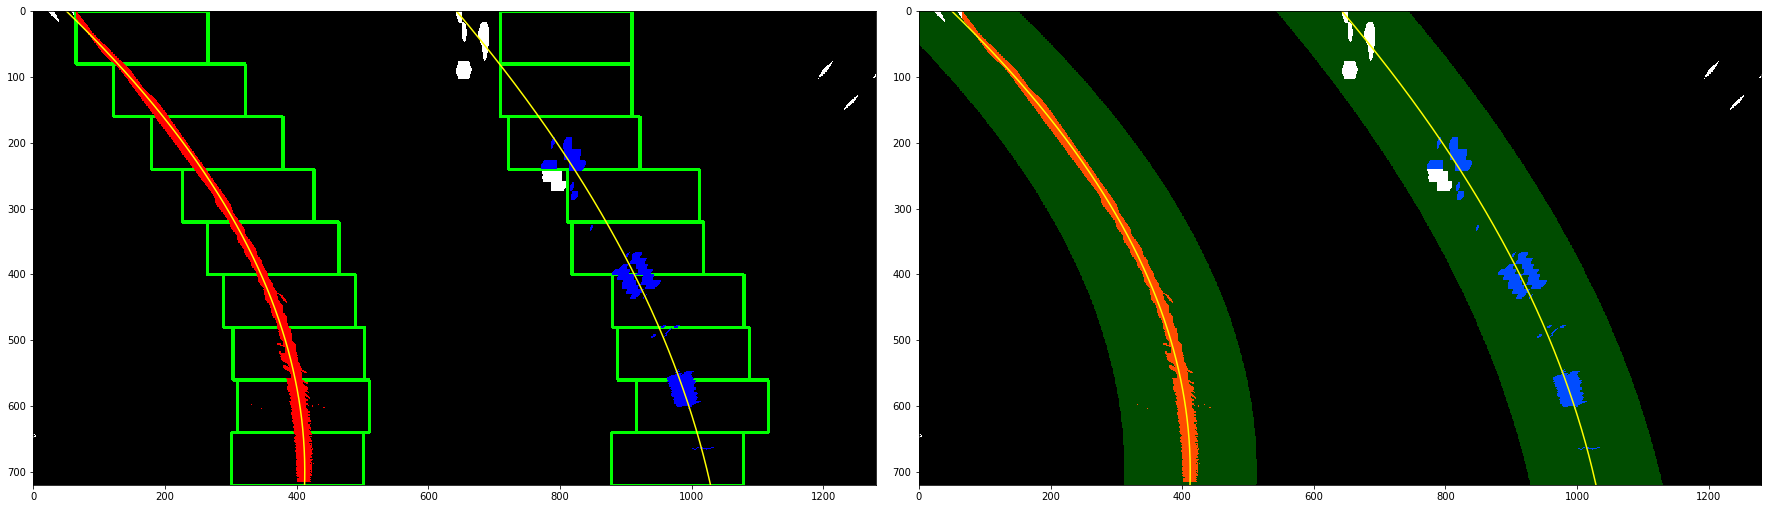

test3.jpg
left_curvature:  319.139423912 m ;  right_curvature:  231.575751441 m


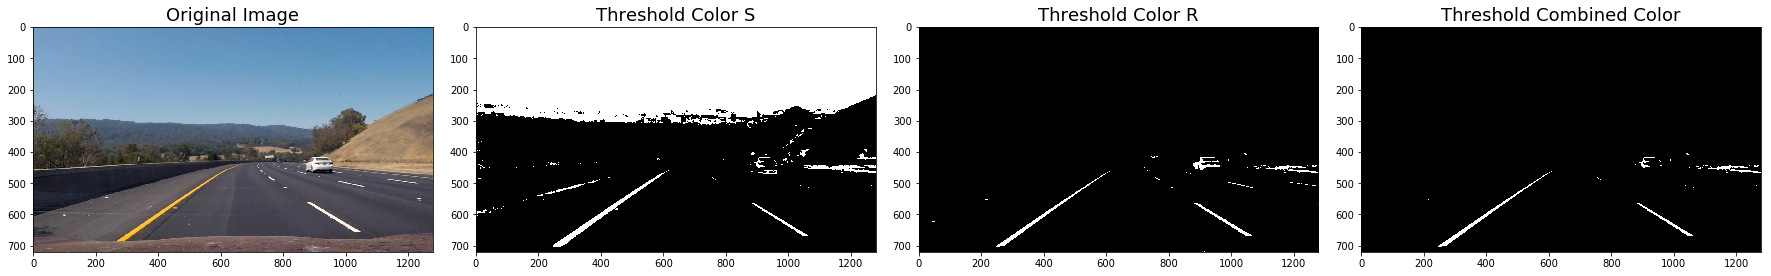

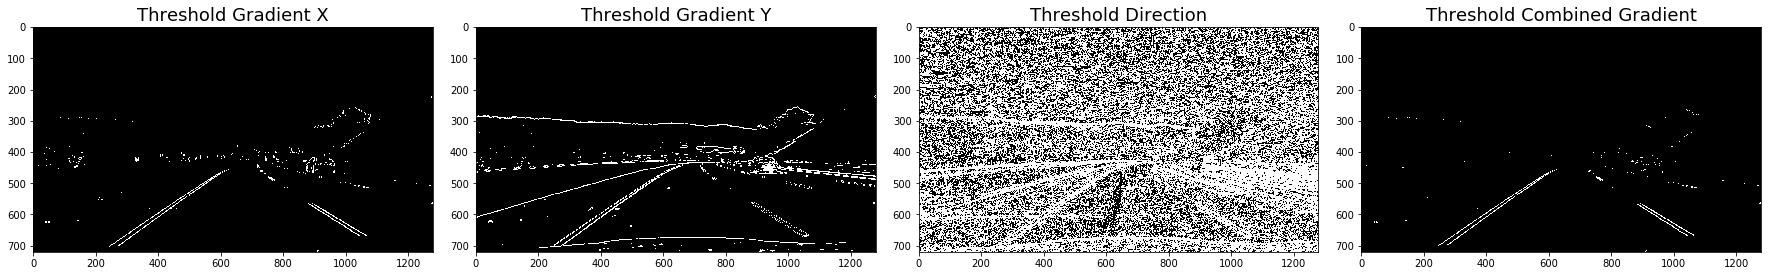

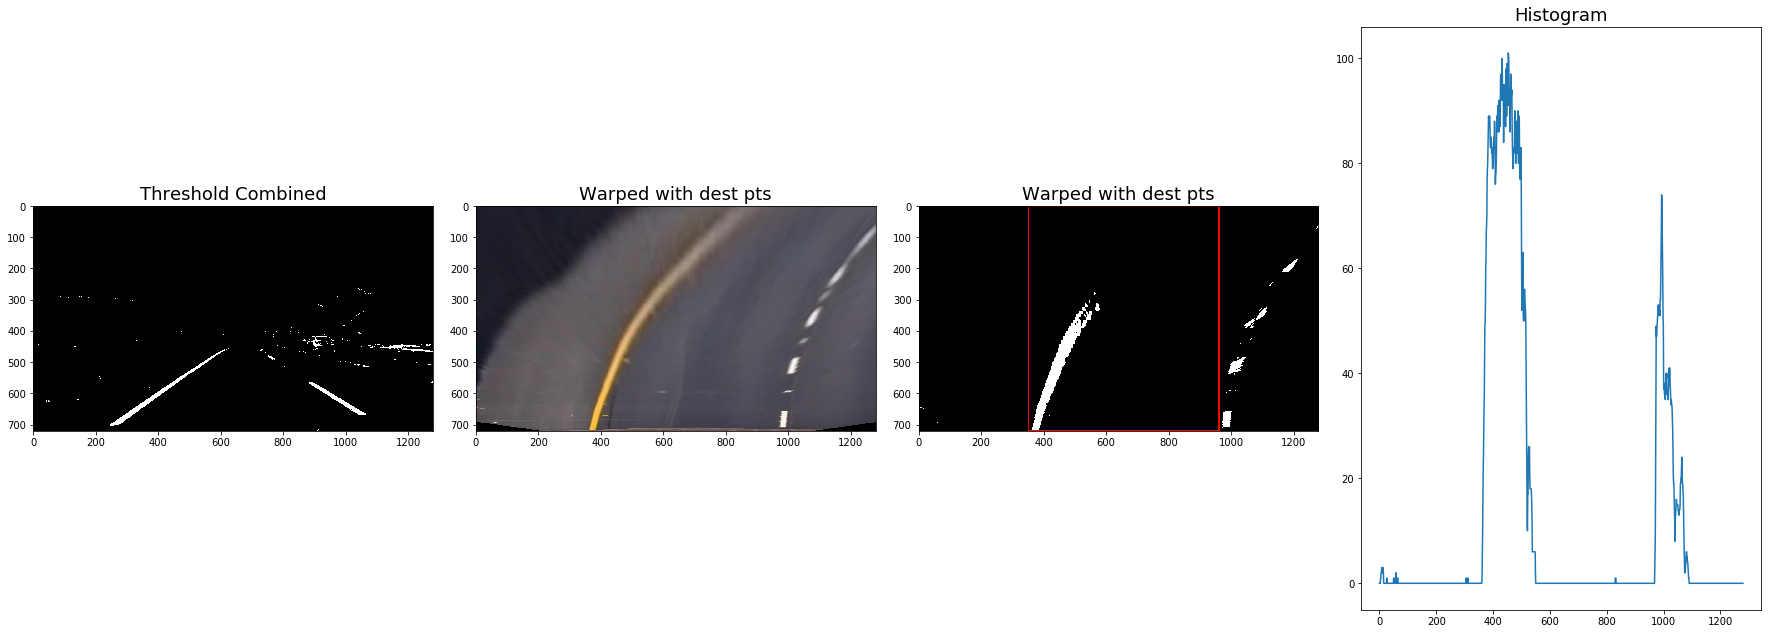

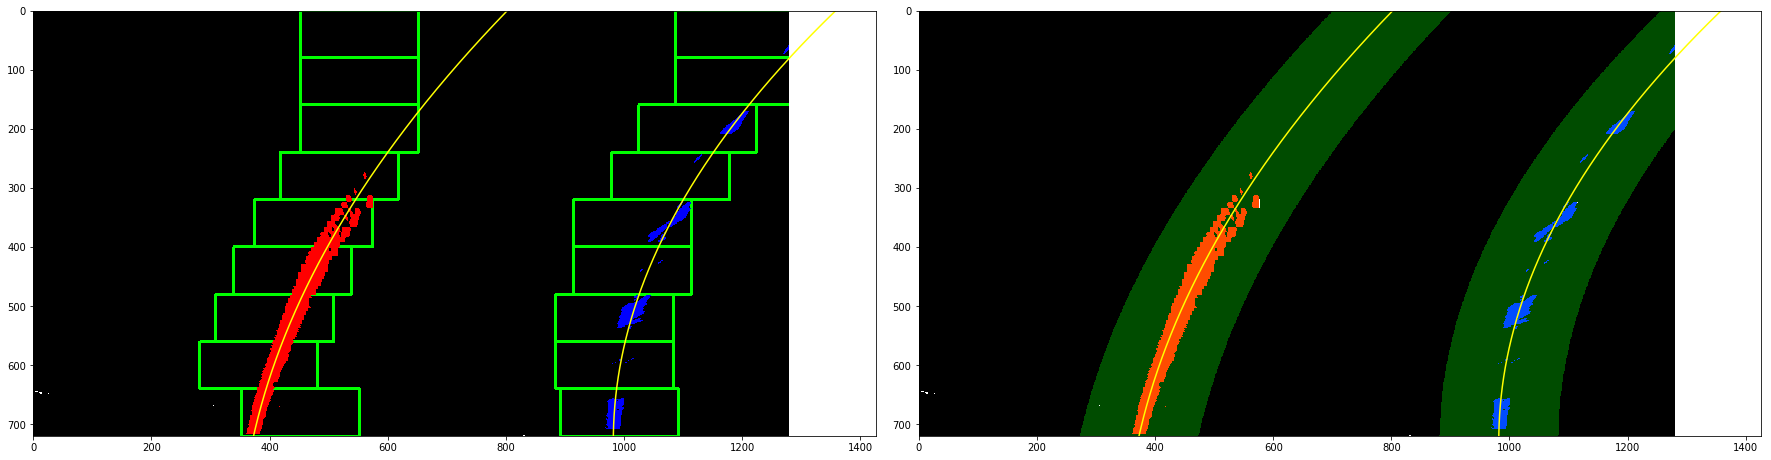

test4.jpg
left_curvature:  436.462128423 m ;  right_curvature:  244.851720986 m


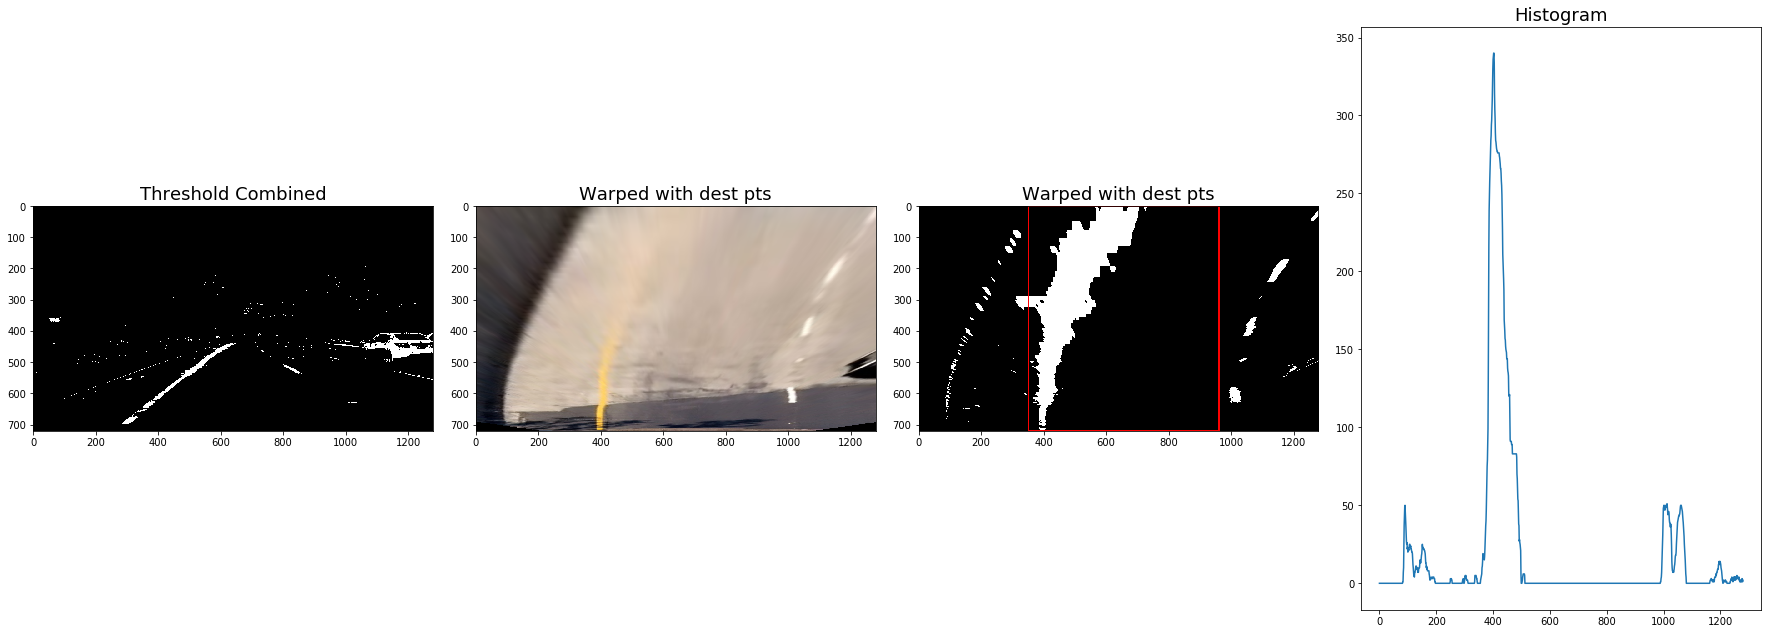

test5.jpg
left_curvature:  211.826814873 m ;  right_curvature:  219.264925814 m


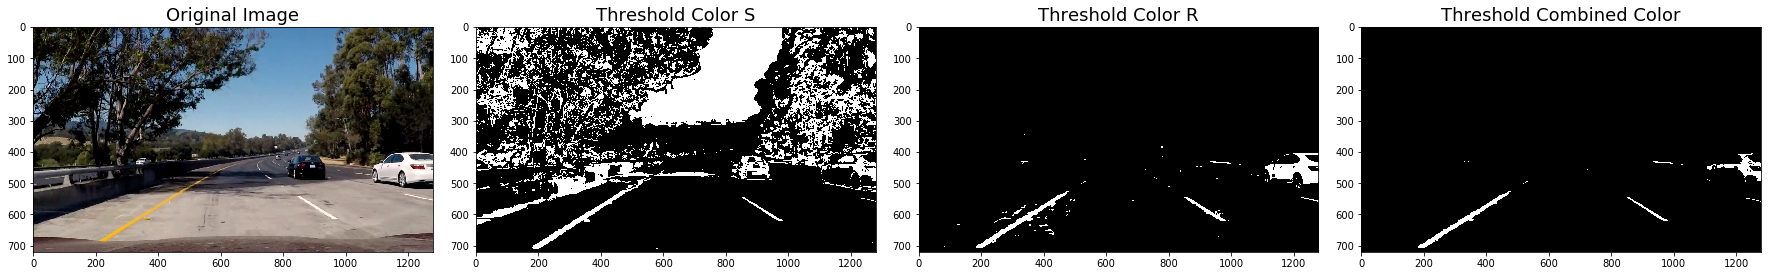

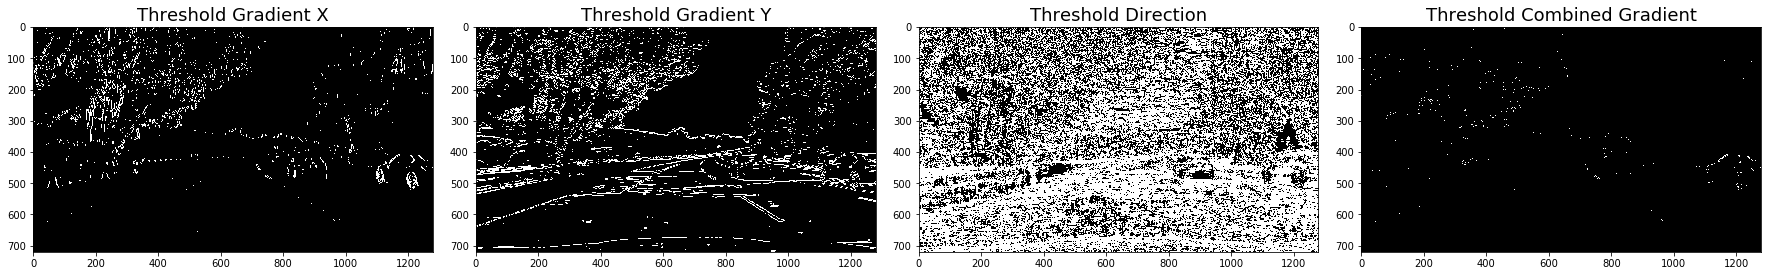

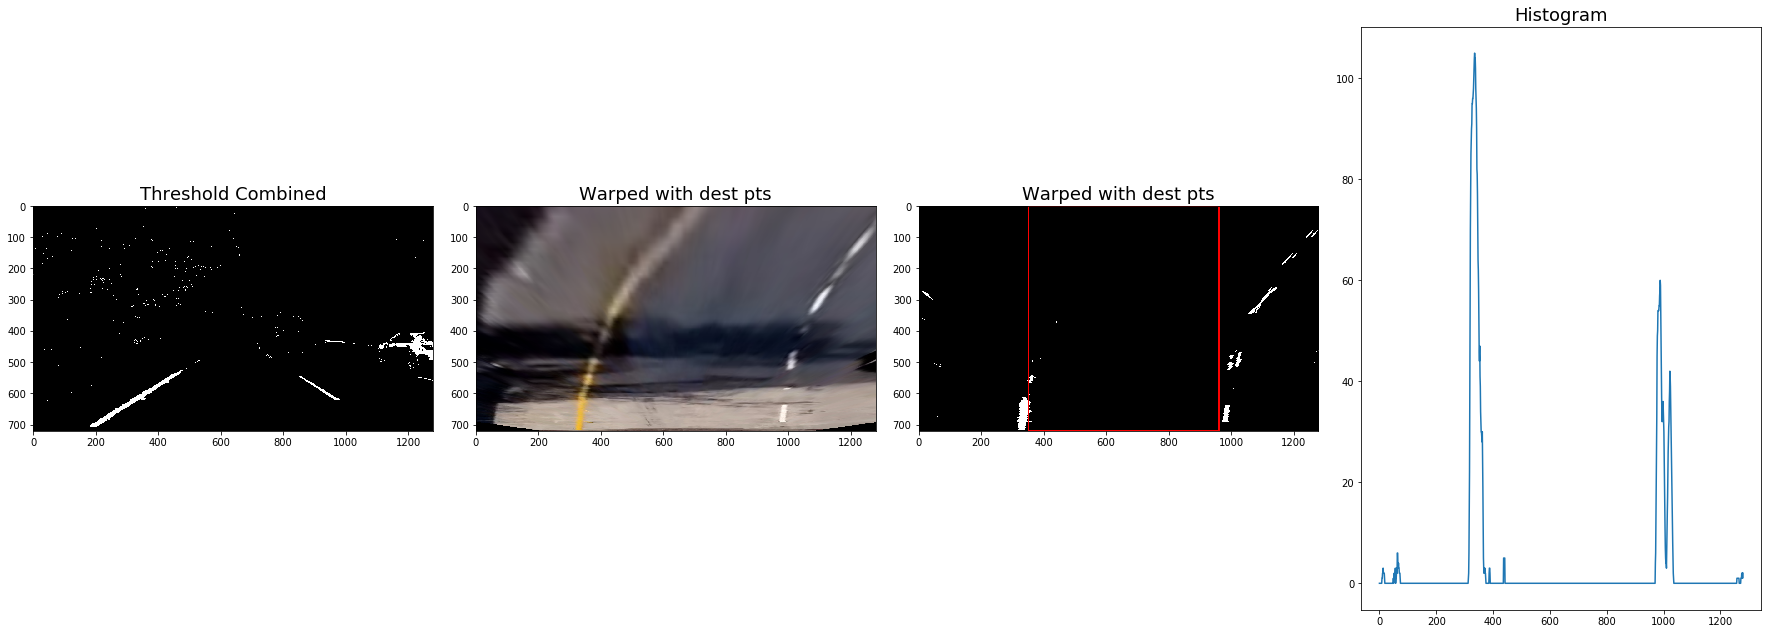

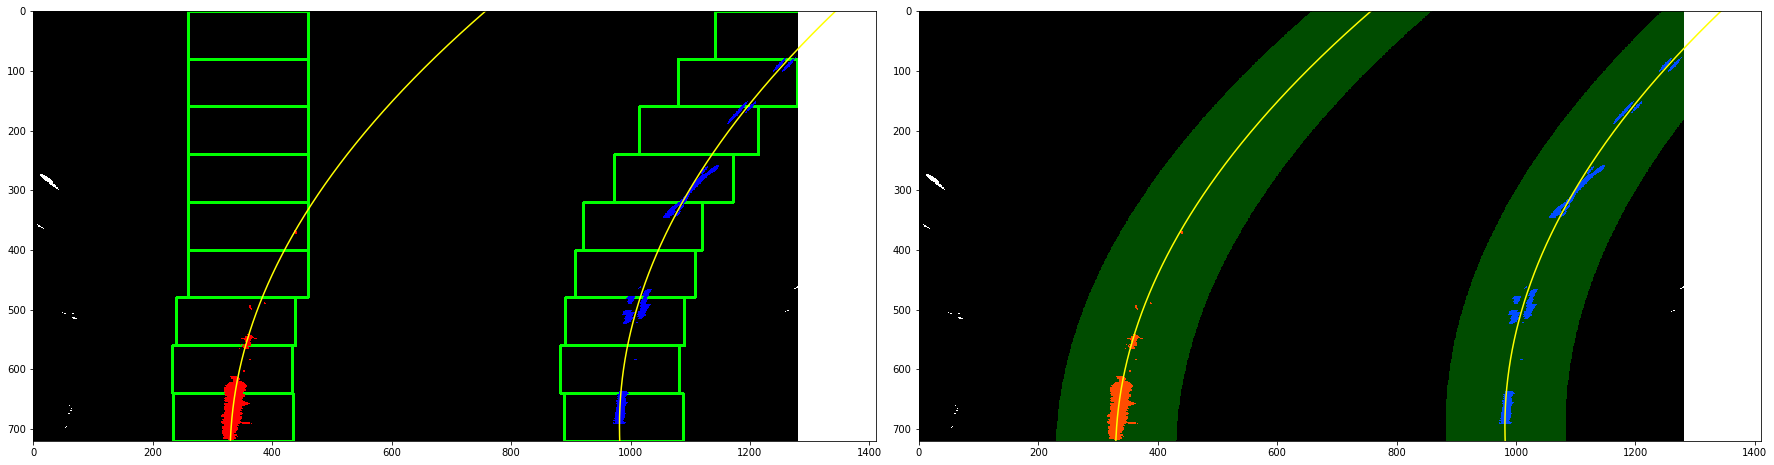

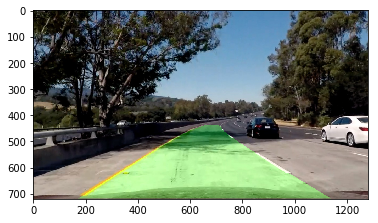

test6.jpg
left_curvature:  479.106850605 m ;  right_curvature:  464.820279756 m


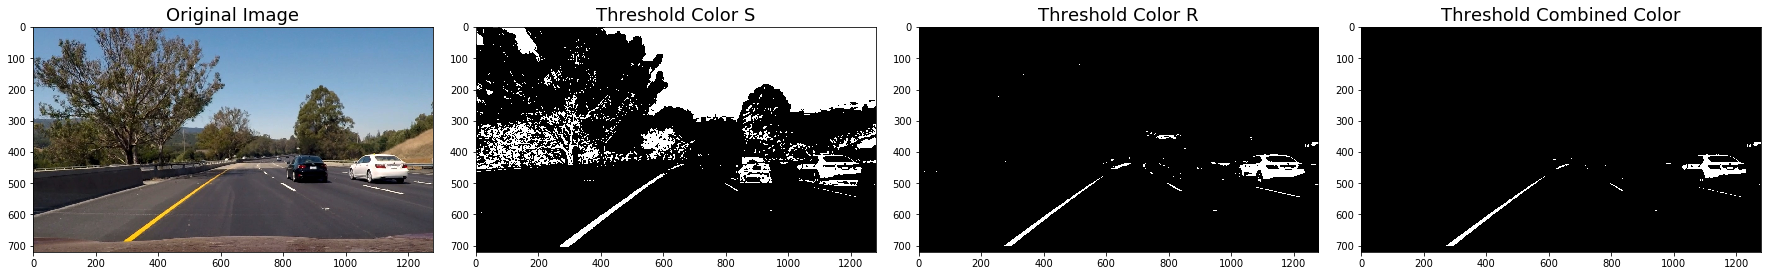

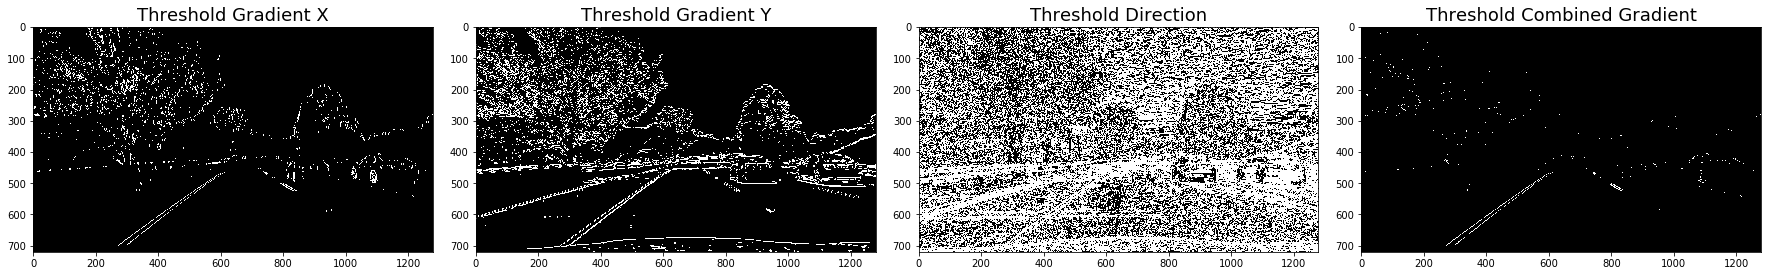

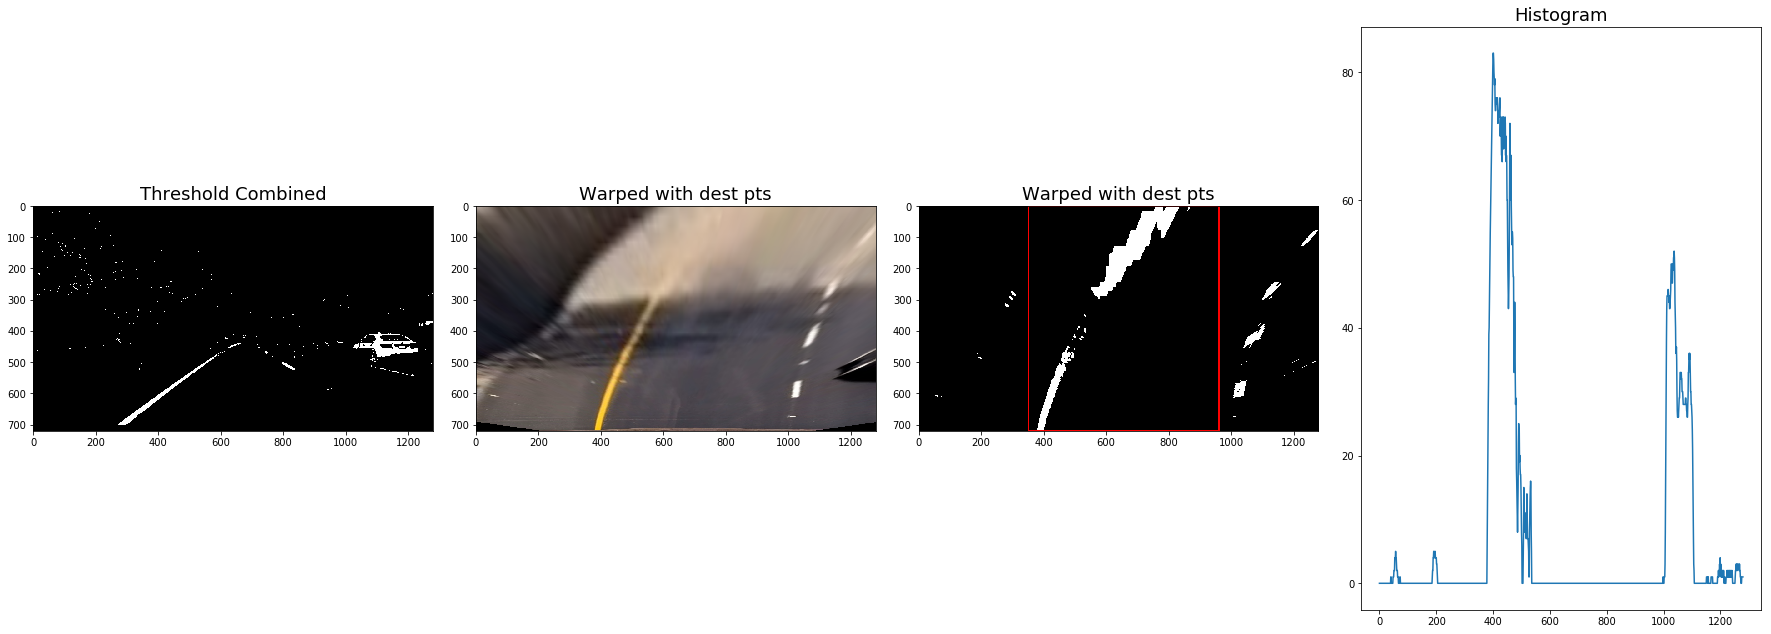

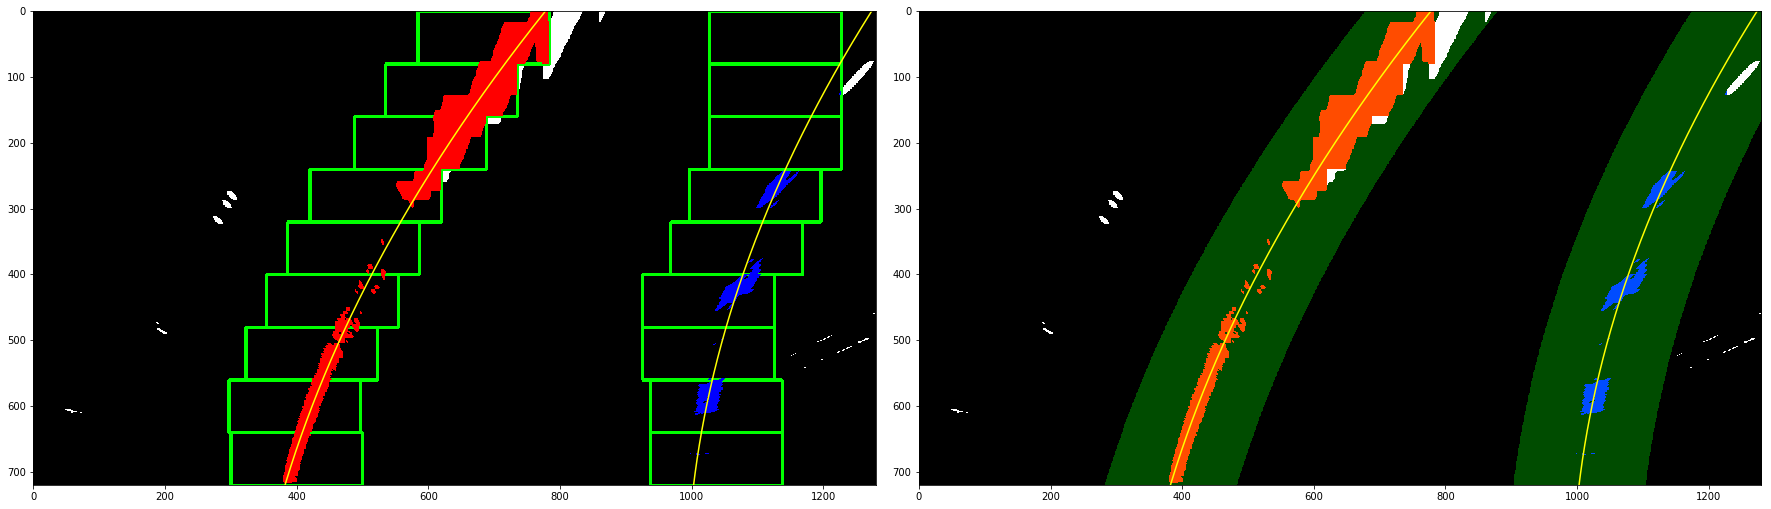

In [16]:
img_cnt=0
images = glob.glob('./test_images/*.jpg')
for fname in images:
    filename = fname.split('/')[-1]
    filename = filename.split('\\')[-1]

    img_cnt+=1
#     if(img_cnt<6 or img_cnt==8):
#         continue
    left_lane_inds = []
    right_lane_inds = []
    
    #read image
    image = cv2.imread(fname)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    undist = undistort(image, mtx, dist)
    
    gray_undist = cv2.cvtColor(undist, cv2.COLOR_RGB2GRAY)
    
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    sobel_x = cv2.Sobel(gray_undist, cv2.CV_64F, 1, 0, ksize = ksize)
    sobel_y = cv2.Sobel(gray_undist, cv2.CV_64F, 0, 1, ksize = ksize)
    gradx = abs_sobel_thresh(sobel_x, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    grady = abs_sobel_thresh(sobel_y, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(sobel_x,sobel_y, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(sobel_x,sobel_y, sobel_kernel=15, thresh=(np.pi/4, np.pi/2))
    grad_binary = np.zeros_like(dir_binary)
    grad_binary[((gradx == 1) & (dir_binary == 1))] = 1 # | ((mag_binary == 1) & (dir_binary == 1))] = 1

    #Apply color threshold
#     s_binary = hls_threshold(undist, ch = 's', thresh = (150,255))
    s_binary = hls_threshold(undist, ch = 's', thresh = (90,255))
    h_binary = hls_threshold(undist, ch = 'h', thresh = (0,100))
    l_binary = hls_threshold(undist, ch = 'l', thresh = (180,255))
    
#     r_binary = rgb_threshold(undist, ch = 'r', thresh = (220,255))
    r_binary = rgb_threshold(undist, ch = 'r', thresh = (200,255))
    g_binary = rgb_threshold(undist, ch = 'g', thresh = (150,255))
    b_binary = rgb_threshold(undist, ch = 'b', thresh = (150,255))   
    
    color_binary = np.zeros_like(s_binary)
    color_binary[(s_binary == 1) & (r_binary == 1)] = 1

    combined = np.zeros_like(gradx)
    combined[(grad_binary == 1) | (color_binary == 1)] = 1
    combined_src, src = draw_roi(combined, 'src')
    
    color_warped, M, Minv = warp(undist)
    binary_warped, M, Minv = warp(combined)
    
    top_dst, dst = draw_roi(binary_warped, 'dst')
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    

    lane_window, lane_poly, left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty , rightx, righty = polyFit(binary_warped, histogram, view='all')

    left_curverad, right_curverad = curveRadius(binary_warped, left_fit, right_fit, ploty)
    
    result = drawLane(undist, binary_warped, left_fit, right_fit, ploty, left_fitx, right_fitx, Minv)

    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    print(filename)
    print('left_curvature: ',left_curverad, 'm', ';  right_curvature: ', right_curverad, 'm')

    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image)
    ax1.set_title('Original Image',fontsize=18)
    ax2.imshow(s_binary, cmap='gray')
    ax2.set_title('Threshold Color S',fontsize=18)
    ax3.imshow(r_binary, cmap='gray')
    ax3.set_title('Threshold Color R',fontsize=18)
    ax4.imshow(color_binary, cmap='gray')
    ax4.set_title('Threshold Combined Color',fontsize=18)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    f.savefig('output_images/color_thresh_'+filename)
    plt.show()
    
#     f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
#     f.tight_layout()
#     ax1.imshow(h_binary, cmap='gray')
#     ax1.set_title('Threshold Color H',fontsize=18)
#     ax2.imshow(l_binary, cmap='gray')
#     ax2.set_title('Threshold Color L', fontsize=18)
#     ax3.imshow(g_binary, cmap='gray')
#     ax3.set_title('Threshold Color G',fontsize=18)
#     ax4.imshow(b_binary, cmap='gray')
#     ax4.set_title('Threshold Color B',fontsize=18)
#     plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
#     plt.show()

    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(gradx, cmap='gray')
    ax1.set_title('Threshold Gradient X',fontsize=18)
    ax2.imshow(grady, cmap='gray')
    ax2.set_title('Threshold Gradient Y', fontsize=18)
    ax3.imshow(dir_binary, cmap='gray')
    ax3.set_title('Threshold Direction',fontsize=18)
    ax4.imshow(grad_binary, cmap='gray')
    ax4.set_title('Threshold Combined Gradient',fontsize=18)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    f.savefig('output_images/grad_thresh_'+filename)
    plt.show()
    
    f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(combined, cmap='gray')
    ax1.set_title('Threshold Combined',fontsize=18)
    ax2.imshow(color_warped, cmap='gray')
    ax2.set_title('Warped with dest pts', fontsize=18)
    ax3.imshow(top_dst, cmap='gray')
    ax3.set_title('Warped with dest pts', fontsize=18)
    ax4.plot(histogram)
    ax4.set_title('Histogram',fontsize=18)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    f.savefig('output_images/combined_thresh_'+filename)
    plt.show()    
    
        
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(24,9))
    f.tight_layout()
    ax1.imshow(lane_window)
    ax1.plot(left_fitx, ploty, color='yellow')
    ax1.plot(right_fitx, ploty, color='yellow')
    ax2.imshow(lane_poly)
    ax2.plot(left_fitx, ploty, color='yellow')
    ax2.plot(right_fitx, ploty, color='yellow')
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    f.savefig('output_images/lane_window_'+filename)
    plt.show()
    
    plt.imshow(result)
    plt.imsave('output_images/result_'+filename, result)
    plt.show()
    
    if(filename=='test2.jpg'):
        
        plt.title('Original')
        plt.imshow(image)
        plt.savefig('output_images/report_images/original.jpg')
        
        plt.title('Undistorted')
        plt.imshow(undist)
        plt.savefig('output_images/report_images/undist.jpg')
        
        plt.title('Undistorted Gray')
        plt.imshow(gray_undist, cmap = 'gray')
        plt.savefig('output_images/report_images/gray_undist.jpg')        

        plt.title('Color Binary')
        plt.imshow(color_binary, cmap='gray')
        plt.savefig('output_images/report_images/color_binary.jpg')
        
        plt.title('Grad Binary')
        plt.imshow(grad_binary, cmap='gray')
        plt.savefig('output_images/report_images/grad_binary.jpg')
        
        plt.title('Combined Binary')
        plt.imshow(combined)
        plt.savefig('output_images/report_images/combined_binary.jpg')
        
        plt.title('Warped')
        plt.imshow(color_warped)
        plt.savefig('output_images/report_images/color_warped.jpg')
        
        plt.title('Binary Warped with dst points')
        plt.imshow(top_dst)
        plt.savefig('output_images/report_images/binary_warped.jpg')
        
        plt.title('Binary with src pts')
        plt.imshow(combined_src)
        plt.savefig('output_images/report_images/binary_src.jpg')
        
        plt.title('Histogram')
        plt.plot(histogram)
        plt.savefig('output_images/report_images/histogram.jpg')
        
        plt.title('Final Output')
        plt.imshow(result)
        plt.savefig('output_images/report_images/result.jpg')
        
        
        f, (ax1, ax2) = plt.subplots(1,2,figsize=(24,9))
        f.tight_layout()
        ax1.imshow(lane_window)
        ax1.plot(left_fitx, ploty, color='yellow')
        ax1.plot(right_fitx, ploty, color='yellow')
        ax2.imshow(lane_poly)
        ax2.plot(left_fitx, ploty, color='yellow')
        ax2.plot(right_fitx, ploty, color='yellow')
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        f.savefig('output_images/report_images/lane_windows.jpg')
        plt.show()


## Line Class

In [17]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self, n):
        
        #buffer length limit to store previous n iter
        self.buffer_limit = n
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None 
        # x values of current fit
        self.current_fitx = None
        # polynomial coefficients of the last n fits of the line
        self.recent_fit = []
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None        
        
    def update(self, fit, ploty, fitx, allx, ally):
        self.current_fit = fit
        self.current_fitx = fitx
        self.allx = allx
        self.ally = ally
        
        #         #update latest x fit
        #         self.current_fitx = self.current_fit[0]*ploty**2 + self.current_fit[1]*ploty + self.current_fit[2] 
        
        #push latest x fit and coeff into buffer
        self.recent_xfitted.append(self.current_fitx) # append x value to the last n fits of the line
        self.recent_fit.append(self.current_fit)# append coefficients to the last n fits of the line
        if(len(self.recent_xfitted)>self.buffer_limit): # if exceeds n, pop out oldest entries
            self.recent_xfitted.pop(0)
            self.recent_fit.pop(0)
#         print('len recent x fitted:',len(self.recent_xfitted) )
        #calculate and store average of last n fit x values
        self.bestx = np.mean(self.recent_xfitted, axis=0)
#         print('best x: ', len(self.bestx) )
        self.best_fit = np.mean(self.recent_fit, axis=0)
#         print('best fit:',len(self.best_fit) )
        
        # Define conversions in x and y from pixels space to meters
        ym_per_pix = 30/720 # meters per pixel in y dimension
        xm_per_pix = 3.7/700 # meters per pixel in x dimension
        self.line_base_pos = (fitx[np.argmax(ploty)]-640)*xm_per_pix

    def diff(self, fit, fitx):
        return (fit - self.recent_fit)
    
    def detect(self, line_base_pos, ploty):
        if(len(self.recent_xfitted)==0):
            self.detected = True
            return
        delta_lane_base = abs(line_base_pos-self.bestx[np.argmax(ploty)])
        if(delta_lane_base<100):
            self.detected = True
        else:
            self.detected = False
        return
      
        

In [18]:
# Define a class to receive the characteristics of each line detection
class Lane():
    def __init__(self, n):
        # two lines of the lane from Class Line
        self.left = Line(n)
        self.right = Line(n)
        
        self.ploty = None
        
        self.image_rgb = None
        
        self.image_undist = None
        
        self.gray_undist = None
        
        self.M = None
        self.Minv = None
        self.binary_warped = None
        self.start = False
        
    def update(self, left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty , rightx, righty):
        self.ploty = ploty
        if(self.left.detected==True):
            self.left.update(left_fit, ploty, left_fitx, leftx, lefty)
        if(self.right.detected==True):
            self.right.update(right_fit, ploty, right_fitx, rightx, righty)
        
        return
    
    def detect(self, left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty , rightx, righty):

        left_lane_pos = left_fitx[np.argmax(ploty)]
        right_lane_pos = right_fitx[np.argmax(ploty)]
        width = right_lane_pos - left_lane_pos
        
        self.left.detect(left_lane_pos, ploty)
        self.right.detect(right_lane_pos, ploty)
        
        if(self.left.detected or self.right.detected):
            return True
        else:
            return False
     

## Define Globals and Calibrate Camera

In [19]:
# mtx, dist = calibrateCam()
lane = Lane(7)

In [20]:
def color_threshold(lane):
    
    undist = lane.image_undist
    
    #Apply color threshold
#   s_binary = hls_threshold(undist, ch = 's', thresh = (150,255))
    s_binary = hls_threshold(undist, ch = 's', thresh = (90,255))
    h_binary = hls_threshold(undist, ch = 'h', thresh = (0,100))
    l_binary = hls_threshold(undist, ch = 'l', thresh = (180,255))
    
#     r_binary = rgb_threshold(undist, ch = 'r', thresh = (220,255))
    r_binary = rgb_threshold(undist, ch = 'r', thresh = (200,255))
    g_binary = rgb_threshold(undist, ch = 'g', thresh = (150,255))
    b_binary = rgb_threshold(undist, ch = 'b', thresh = (150,255))   
    
    color_binary = np.zeros_like(s_binary)
    color_binary[(s_binary == 1) & (r_binary == 1)] = 1
    
    return color_binary
    
def grad_threshold(lane):
    
    gray_undist = lane.gray_undist
    # Choose a Sobel kernel size
    ksize = 5 # Choose a larger odd number to smooth gradient measurements
    # Apply each of the thresholding functions
    sobel_x = cv2.Sobel(gray_undist, cv2.CV_64F, 1, 0, ksize = ksize)
    sobel_y = cv2.Sobel(gray_undist, cv2.CV_64F, 0, 1, ksize = ksize)
    gradx = abs_sobel_thresh(sobel_x, orient='x', sobel_kernel=ksize, thresh=(50, 255))
    grady = abs_sobel_thresh(sobel_y, orient='y', sobel_kernel=ksize, thresh=(30, 100))
    mag_binary = mag_thresh(sobel_x,sobel_y, sobel_kernel=ksize, mag_thresh=(30, 100))
    dir_binary = dir_threshold(sobel_x,sobel_y, sobel_kernel=15, thresh=(np.pi/4, np.pi/2))
    grad_binary = np.zeros_like(dir_binary)
    grad_binary[((gradx == 1) & (dir_binary == 1))] = 1 # | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return grad_binary

def filter_image(lane):
    
    lane.gray_undist = convert2gray(lane.image_undist, fmt='RGB')
    
    color_binary = color_threshold(lane)
    grad_binary = grad_threshold(lane)
    
    combined = np.zeros_like(grad_binary)
    combined[(grad_binary == 1) | (color_binary == 1)] = 1   
    
    lane.binary_warped, lane.M, lane.Minv = warp(combined)
    

In [21]:
def calc_width(ploty, left_fitx, right_fitx):
    width = right_fitx[np.argmax(ploty)] - left_fitx[np.argmax(ploty)]
#     print('right_base: ', right_fitx[np.argmax(ploty)])
#     print('left_base: ', left_fitx[np.argmax(ploty)])
    return width  
        

In [22]:
def lane_process(lane):
    
    binary_warped = lane.binary_warped
    M = lane.M
    Minv = lane.Minv
    undist = lane.image_undist
    
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    
    if(lane.start==False):
        lane_window, lane_poly, left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty , rightx, righty = polyFit(binary_warped, histogram, view='None')
        lane.start = True
    else:
        lane_poly, left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty , rightx, righty = polyFit2(binary_warped, lane.left.current_fit, lane.right.current_fit, view='None')
    
    
    left_curverad, right_curverad = curveRadius(binary_warped, left_fit, right_fit, ploty)
    #     print(left_curverad, 'm', right_curverad, 'm')
    
    if(lane.detect(left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty , rightx, righty)):
        lane.update(left_fit, right_fit, ploty, left_fitx, right_fitx, leftx, lefty , rightx, righty)   
        lane.left.radius_of_curvature = left_curverad
        lane.right.radius_of_curvature = right_curverad
    
    result = drawLane(undist, binary_warped, lane.left.best_fit, lane.right.best_fit, lane.ploty, lane.left.bestx, lane.right.bestx, Minv)
#     result = drawLane(undist, binary_warped, lane.left.current_fit, lane.right.current_fit, lane.ploty, lane.left.current_fitx, lane.right.current_fitx, Minv)
    
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    left_line_base_pos = left_fitx[np.argmax(ploty)]
    right_line_base_pos = right_fitx[np.argmax(ploty)]
    
#     print('base left: ', left_line_base_pos)
#     print('base right: ', right_line_base_pos)

    lane_width = calc_width(ploty, left_fitx, right_fitx)
#     print('lane_width:', lane_width)
    lane_center = (lane.left.bestx[np.argmax(ploty)] + lane.right.bestx[np.argmax(ploty)])/2
    car_center = 1280.0/2.0
    
    distance_from_center = round(((car_center - lane_center)*xm_per_pix*100)+0.05, 2)
    
    font = cv2.FONT_HERSHEY_SIMPLEX
    str1 = str('Distance from Center: '+ str(distance_from_center) +'cm')
    cv2.putText(result,str1,(680,30), font, 1,(255,255,255),2,cv2.LINE_AA)
#     if left.radius_of_curvature and right.radius_of_curvature:
    curvature = 0.5*(round(lane.right.radius_of_curvature/1000.0+0.05,2) + round(lane.left.radius_of_curvature/1000.0+0.05,2))
    str2 = str('Curvature: '+ str(curvature) +'km')
    cv2.putText(result,str2,(680,70), font, 1,(255,255,255),2,cv2.LINE_AA)
    
    return result    

In [23]:
def process_image(image):
    global lane
    global left_lane_inds
    global right_lane_inds
    left_lane_inds = []
    right_lane_inds = []
        
    lane.image_rgb = image
    
    lane.image_undist = undistort(image, mtx, dist)
    
    filter_image(lane)
    
    result = lane_process(lane)
    
    return result

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`project_video.mp4`

`challenge_video.mp4`

`harder_challenge_video.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [24]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

Let's try the one with the solid white lane on the right first ...

In [ ]:
project_out = 'project_out.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
# clip1 = VideoFileClip("project_video.mp4").subclip(38,43)
clip1 = VideoFileClip("project_video.mp4")
video_out = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time video_out.write_videofile(project_out, audio=False)

[MoviePy] >>>> Building video project_out.mp4
[MoviePy] Writing video project_out.mp4


 99%|█████████████████████████████████████████████████████████████████████████████▍| 1252/1261 [06:28<00:02,  3.38it/s]

Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_out))